
<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./CooksMembraneBbar.ipynb" download="CooksMembraneBbar.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=CooksMembraneBbar.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/Mechanics/CooksMembrane/CooksMembraneBbar.py"><img src="https://img.shields.io/static/v1?label=Source:&message=CooksMembraneBbar.py&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/6.5.6-0.7.0?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/Mechanics/CooksMembrane/CooksMembraneBbar.py%26branch=6.5.6%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>

$$
\newcommand{\B}{\text{B}}
\newcommand{\F}{\text{F}}
\newcommand{\I}{\mathbf I}
\newcommand{\intD}[1]{\int_{\Omega_e}#1\mathrm{d}\Omega}
$$

# Cook's membrane example for nearly icompressible solid

## B bar method
Considering a strain decomposition: $\mathbf\epsilon = \underbrace{\mathbf\epsilon- \frac{1}{3}(\epsilon:\mathbf I)}_{\text{deviatoric}}\I +  \underbrace{\frac{1}{3}(\epsilon:\mathbf I)}_{\text{dilatational}} \I$.
The idea of the B bar method is to use another quadrature rule to interpolate the dilatational part, which leads to a modified B matrix [1]:
$$
	     \bar\B = \underbrace{\B - \B^{\text{dil}}}_{\text{original B elements}}+ \underbrace{{\bar\B}^{\text{dil}}}_{\text{by another quadrature rule} }
$$
There are several methods to form ${\bar\B}^{\text{dil}}$ such as selective integration, generalization of the mean-dilatation formulation.
In the current OGS, we use the latter, which reads
$$
		  {\bar\B}^{\text{dil}} = \frac{\intD{\B^{\text{dil}}(\xi)}}{\intD{}}
$$

## Example
To verify the implementation of the B bar method, the so called Cook's membrane is used as a benchmark.
Illustrated in the following figure, this example simulates a tapered and swept panel of unit thickness.
The left edge is clamped and the right edge is applied with a distributed shearing load $F$ = 100 N/mm.
The plane strain condition is considered.
This numerical model is exactly the same as that is presented in the paper by T. Elguedj et al [1,2].

<img src="figures/cooks_membrane.png" alt="Cook's membrane" width="320" height="320" />


In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import ogstools as ot

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
out_dir.mkdir(parents=True, exist_ok=True)

In [2]:
def run_single_test(n: int, use_bbar: bool) -> ot.MeshSeries:
    model = ot.Project(
        input_file="CooksMembrane.prj", output_file=out_dir / "modified.prj"
    )
    model.replace_text(f"mesh_n{n:02d}.vtu", xpath="./mesh")
    model.replace_text(str(use_bbar).lower(), xpath="./processes/process/use_b_bar")
    prefix = f"cooks_membrane_n_{n}_bbar_{str(use_bbar).lower()}"
    model.replace_text(prefix, xpath="./time_loop/output/prefix")
    model.replace_text("BiCGSTAB", xpath=".//solver_type")
    model.replace_text("ILUT", xpath=".//precon_type")
    model.write_input()
    model.run_model(logfile=out_dir / "out.txt", args=f"-o {out_dir} -m .")
    return ot.MeshSeries(out_dir / (prefix + ".pvd"))


def get_top_uy(mesh: ot.Mesh) -> np.ndarray:
    top_point = (48.0e-3, 60.0e-3, 0)
    p_id = mesh.find_closest_point(top_point)
    return mesh.point_data["displacement"][p_id, 1]


def compare(mesh_a: ot.Mesh, mesh_b: ot.Mesh) -> plt.Figure:
    fig, axs = plt.subplots(2, 2, figsize=[8, 6], sharex=True, sharey=True)
    u = ot.variables.displacement["y"].replace(output_unit="mm")
    sig_tr = ot.variables.stress.trace
    ot.plot.contourf(mesh_a, u, fig=fig, ax=axs[0, 0], show_edges=True)
    ot.plot.contourf(mesh_b, u, fig=fig, ax=axs[0, 1], show_edges=True)
    ot.plot.contourf(mesh_a, sig_tr, fig=fig, ax=axs[1, 0], show_edges=True)
    ot.plot.contourf(mesh_b, sig_tr, fig=fig, ax=axs[1, 1], show_edges=True)
    axs[0, 0].set_title("bbar = false")
    axs[0, 1].set_title("bbar = true")
    ot.plot.utils.update_font_sizes(fig.axes, 10)
    return fig


n_range = [4, 10, 15, 20, 25, 30]

In [3]:
results_bbar_false = {n: run_single_test(n, use_bbar=False) for n in n_range}
uy_top_bbar_false = [get_top_uy(ms[-1]) for ms in results_bbar_false.values()]
uy_top_bbar_false_ref = np.array(
    [0.002164586784123102, 0.0022603329644579383, 0.002375295856067169,
     0.002519725590136146, 0.0026515294133790837, 0.002868289617025223]
)  # fmt: skip
np.testing.assert_allclose(uy_top_bbar_false, uy_top_bbar_false_ref, atol=1e-10)

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/CooksMembrane/CooksMembraneBbar/modified.prj
Status: finished successfully.
Execution took 0.15464329719543457 s
Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/CooksMembrane/CooksMembraneBbar/modified.prj
Status: finished successfully.
Execution took 0.1632981300354004 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/CooksMembrane/CooksMembraneBbar/modified.prj
Status: finished successfully.
Execution took 0.16602182388305664 s
Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/CooksMembrane/CooksMembraneBbar/modified.prj
Status: finished successfully.
Execution took 0.17988967895507812 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/CooksMembrane/CooksMembraneBbar/modified.prj
Status: finished successfully.
Execution took 0.18856167793273926 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/CooksMembrane/CooksMembraneBbar/modified.prj
Status: finished successfully.
Execution took 0.21787452697753906 s


In [4]:
results_bbar_true = {n: run_single_test(n, use_bbar=True) for n in n_range}
uy_top_bbar_true = [get_top_uy(ms[-1]) for ms in results_bbar_true.values()]
uy_top_bbar_true_ref = np.array(
    [0.006957471385697900, 0.007772616910217863, 0.007897597955618913,
     0.007951479575082158, 0.007976349858390623, 0.007999718483861992]
)  # fmt: skip
np.testing.assert_allclose(uy_top_bbar_true, uy_top_bbar_true_ref, atol=2e-4)

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/CooksMembrane/CooksMembraneBbar/modified.prj
Status: finished successfully.
Execution took 0.15346360206604004 s
Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/CooksMembrane/CooksMembraneBbar/modified.prj
Status: finished successfully.
Execution took 0.16380095481872559 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/CooksMembrane/CooksMembraneBbar/modified.prj
Status: finished successfully.
Execution took 0.16449666023254395 s
Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/CooksMembrane/CooksMembraneBbar/modified.prj
Status: finished successfully.
Execution took 0.17616605758666992 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/CooksMembrane/CooksMembraneBbar/modified.prj
Status: finished successfully.
Execution took 0.18763518333435059 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/CooksMembrane/CooksMembraneBbar/modified.prj
Status: finished successfully.
Execution took 0.2247016429901123 s


## Result

### Vertical diplacement at the top point

The following figure shows that the convergence of the solutions obtained by using the B bar method follows the one presented in the paper by T. Elguedj et al [1]. However, the results obtained without the B bar method are quit far from the converged solution with the finest mesh.

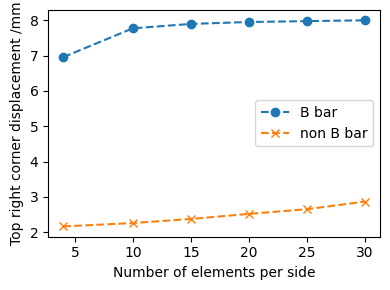

In [5]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(n_range, np.asarray(uy_top_bbar_true) * 1e3, "--o", label="B bar")
ax.plot(n_range, np.asarray(uy_top_bbar_false) * 1e3, "--x", label="non B bar")
ax.set_xlabel("Number of elements per side")
ax.set_ylabel("Top right corner displacement /mm")
ax.legend()
fig.tight_layout()

### Comparison of results

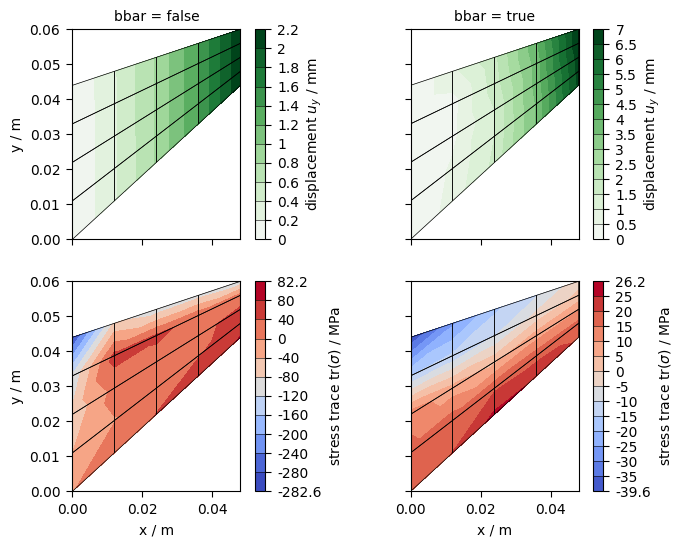

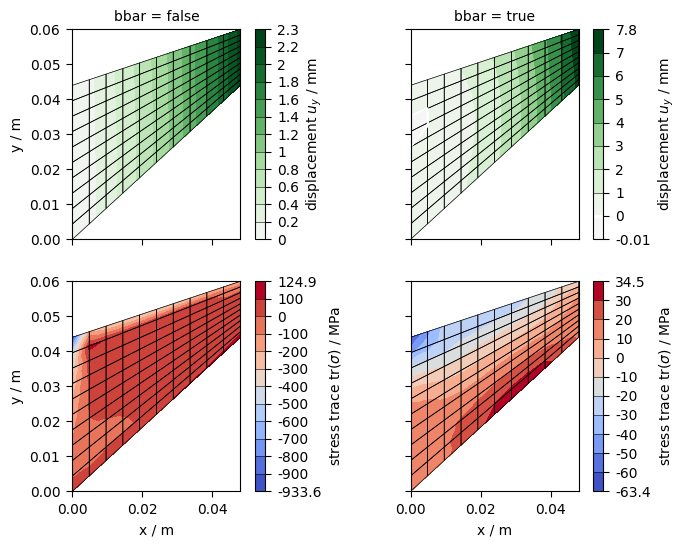

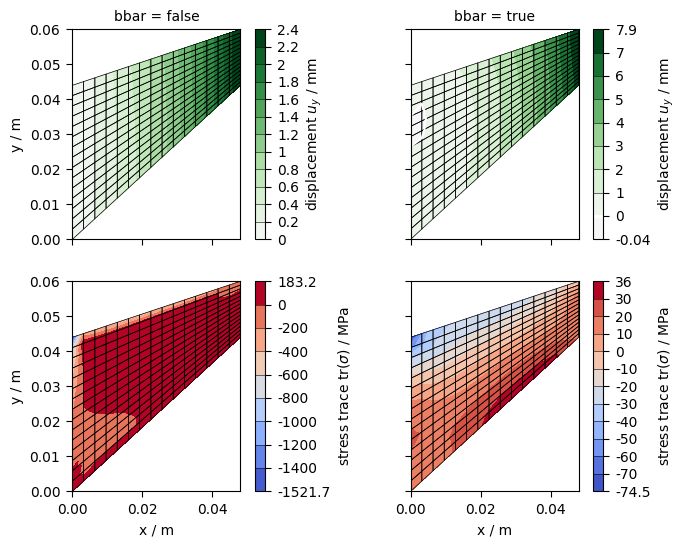

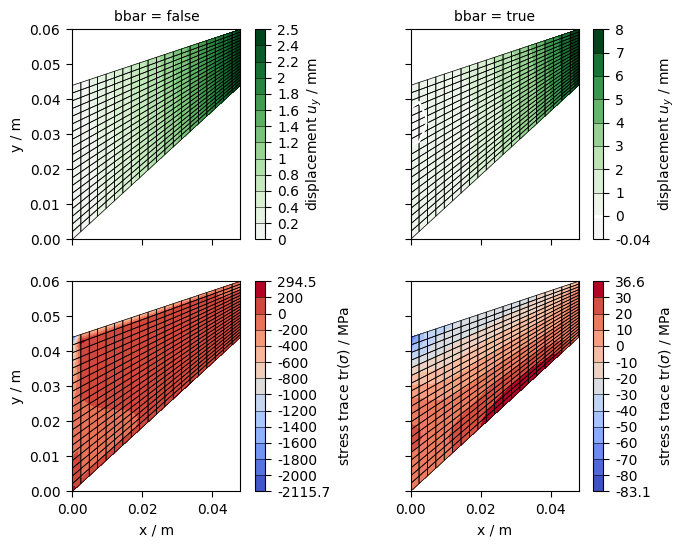

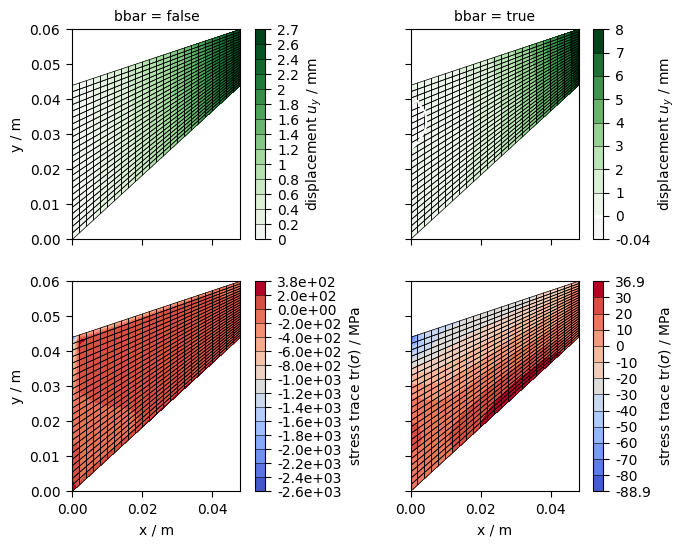

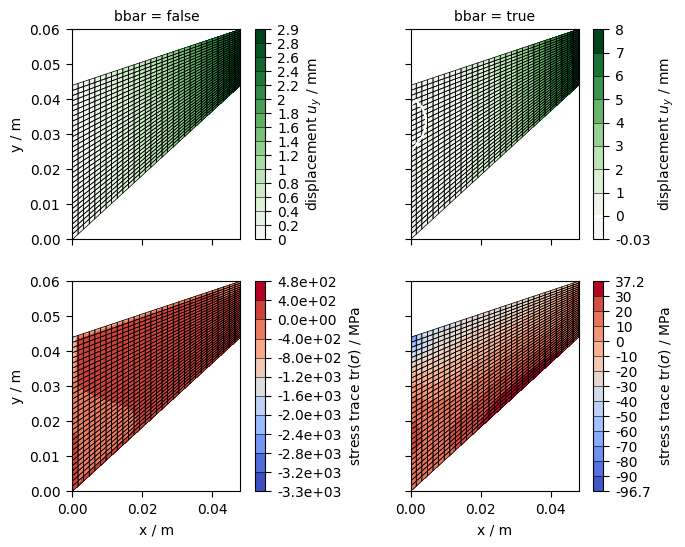

In [6]:
for n in n_range:
    compare(results_bbar_false[n][-1], results_bbar_true[n][-1])

The contour plots show that even with the coarsest mesh, the B bar method still gives reasonable stress results.

## Reference

[1] T.J.R. Hughes (1980). Generalization of selective integration procedures to anisotropic and nonlinear media. International Journal for Numerical Methods in Engineering, 15(9), 1413-1418.

[2] T. Elguedj, Y. Bazilevs, V.M. Calo, T.J.R. Hughes (2008),
 $\bar\B$ and $\bar\F$ projection methods for nearly incompressible linear and non-linear elasticity and plasticity using higher-order NURBS elements, Computer Methods in Applied Mechanics and Engineering, 197(33--40), 2732-2762.
